In [2]:
import algorithms_comp as alg
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import time
import pickle
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal as mltnorm
from scipy.sparse import csr_matrix
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
%matplotlib inline

In [3]:
from functions import *

In [4]:
from algorithms_comp import *

In [5]:
from utils import *

# Logistic regression

## heart

In [6]:
%%time
dataset = "heart"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions in the sum: ", m, ", dimension of the problem: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness constant of the sum: ", L)
print("Average smoothness constant   : ", average_L)
print("Worst smoothness constant     : ", worst_L)
print("Fraction of non-zero elemenst : ", sparsity_A)

Number of functions in the sum:  270 , dimension of the problem:  13
Smoothness constant of the sum:  26710.680138975204
Average smoothness constant   :  27147.725435185188
Worst smoothness constant     :  90369.64000000001
Fraction of non-zero elemenst :  0.750997150997151
CPU times: total: 31.2 ms
Wall time: 29 ms


### Find the solution

In [7]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [8]:
%%time
param = [A, y, l2, False]
res_solver = minimize(logreg_loss, x_init, args = param, jac=logreg_grad, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-30)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

True
0.34746010982135006
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.34746010982135006
        x: [-5.428e-02  1.087e+00 ...  1.157e+00  3.493e-01]
      nit: 1351
      jac: [-4.602e-09  1.073e-08 ...  6.711e-09  1.908e-09]
     nfev: 1598
     njev: 1598
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 500 ms
Wall time: 494 ms


In [9]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Parameters

In [10]:
l2 = 0
l1 = 0
sparse = False
sparse_full = True


bs = 100

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 0.5
x_init[0:num_of_non_zeros] += shift_param
N = 1000000

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)


print("f(x_0)-f(x^*) = ", logreg_loss(x_init, [A, y, l2, False, 1]) - f_star)
epsilon = 1e-3

f(x_0)-f(x^*) =  13.239656902213394


# Tests

In [45]:
N = 50000
step_param = 1
batch_sizes = [10]
overbatching_cnst = 4 * A.shape[1] * (3 * 125)
delta = 0
print(f'Theoretical overbatching cnst is {overbatching_cnst}')

for bs in batch_sizes:
    theoretical_rho = max(1, overbatching_cnst / bs)
    rhos = [theoretical_rho, theoretical_rho / 10, theoretical_rho / 100] 
    for rho in rhos:
        args = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, 1e-10]

        Our_method = ZO_AccSGD(filename, x_init, args=args, bs=bs, N=N,
                               f_star=f_star, x_star=x_star, tuning_stepsize_param=1)
        
        print(f'Finished with theoretical stepsize {1 / (L * rho)} and rho = {rho}')

Theoretical overbatching cnst is 19500
1950.0


100%|██████████| 50000/50000 [04:13<00:00, 197.57it/s]


Finished with theoretical stepsize 1.919908104744307e-08 and rho = 1950.0
195.0


100%|██████████| 50000/50000 [04:11<00:00, 198.61it/s]


Finished with theoretical stepsize 1.9199081047443069e-07 and rho = 195.0
19.5


100%|██████████| 50000/50000 [04:12<00:00, 198.37it/s]

Finished with theoretical stepsize 1.919908104744307e-06 and rho = 19.5


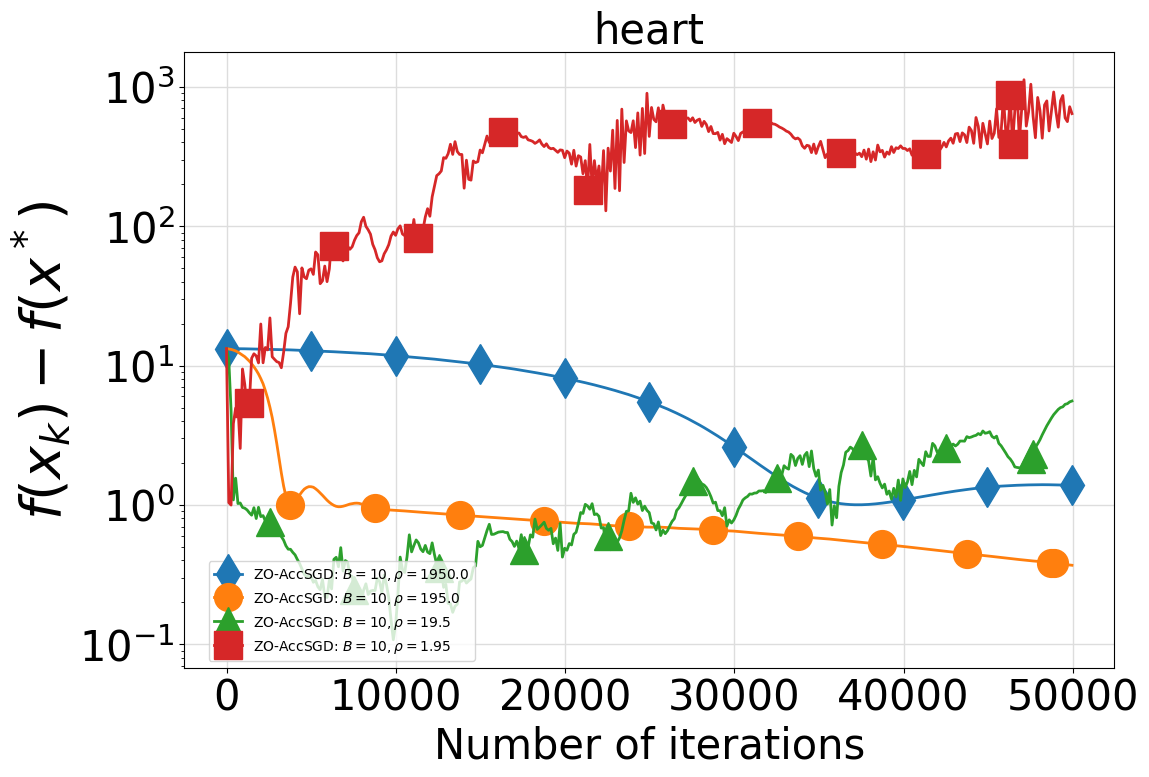

In [46]:
methods = []
N = 50000
step_param = 1
batch_sizes = [10]
overbatching_cnst = 4 * A.shape[1] * (3 * 125)
delta = 0

for bs in batch_sizes:
    theoretical_rho = max(1, overbatching_cnst / bs)
    rhos = [theoretical_rho, theoretical_rho / 10, theoretical_rho / 100, theoretical_rho / 1000] 
    for rho in rhos:
        methods.append(['Our_algorithm logreg', [step_param, N, delta, bs, rho],
                        fr"ZO-AccSGD: $B = {bs}, \rho = {rho}$", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+"_rho_"+str(rho)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [47]:
N = 100000
step_param = 1
bs = 10
overbatching_cnst = 4 * A.shape[1] * (3 * 125)
smoothing_params = [1e-10]
delta = 0
print(f'Theoretical overbatching cnst is {overbatching_cnst}')
theoretical_rho = max(1, overbatching_cnst / bs)
rhos = [theoretical_rho, theoretical_rho / 10]

for smoothing_param in smoothing_params:
    for rho in rhos:
        args = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, smoothing_param]

        Our_method = ZO_AccSGD(filename, x_init, args=args, bs=bs, N=N,
                               f_star=f_star, x_star=x_star, tuning_stepsize_param=1)
        
        print(f'Finished, params: rho = {rho}, h = {smoothing_param}')

Theoretical overbatching cnst is 19500
1950.0


100%|██████████| 100000/100000 [08:12<00:00, 202.97it/s]


Finished, params: rho = 1950.0, h = 1e-10
195.0


100%|██████████| 100000/100000 [08:10<00:00, 204.00it/s]

Finished, params: rho = 195.0, h = 1e-10


Theoretical overbatching cnst is 19500


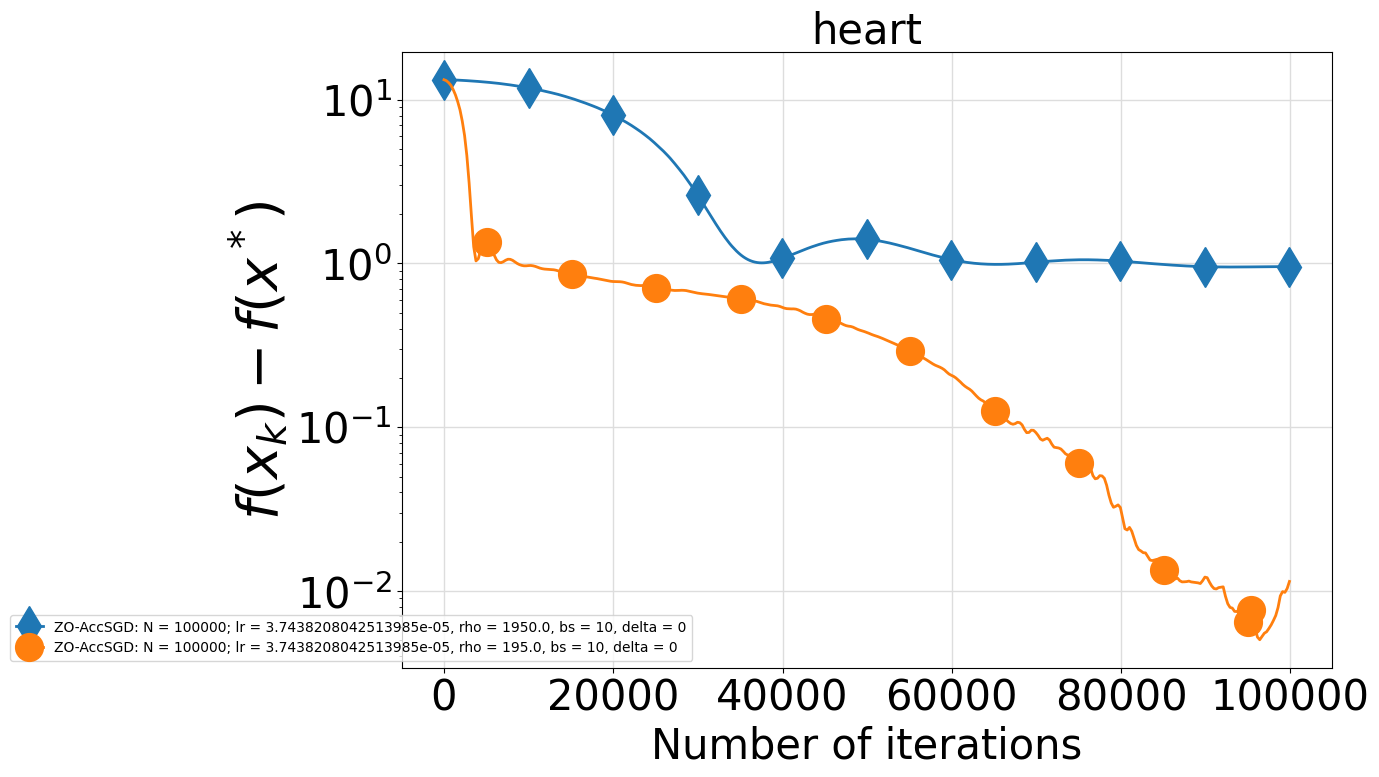

In [48]:
methods = []
N = 100000
step_param = 1
bs = 10
overbatching_cnst = 4 * A.shape[1] * (3 * 125)
smoothing_params = [1e-10]
delta = 0
print(f'Theoretical overbatching cnst is {overbatching_cnst}')
theoretical_rho = max(1, overbatching_cnst / bs)
rhos = [theoretical_rho, theoretical_rho / 10]

for smoothing_param in smoothing_params:
    for rho in rhos:
        methods.append(['Our_algorithm logreg', [step_param, N, delta, bs, rho],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs}, delta = {delta}", None])
mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [63]:
N = 10000
step_param = 1
bs = 100
overbatching_cnst = 4 * A.shape[1] * (3 * 125)
smoothing_param = 1e-10
delta = 0
print(f'Theoretical overbatching cnst is {overbatching_cnst}')
theoretical_rho = max(1, overbatching_cnst / bs)
rhos = [theoretical_rho, theoretical_rho / 10]

for rho in rhos:
    args = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, smoothing_param]

    Our_method = ZO_AccSGD(filename, x_init, args=args, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=1)
    
    print(f'Finished, params: B = {bs}, rho = {rho}')

Theoretical overbatching cnst is 19500
195.0


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [08:36<00:00, 19.35it/s]


Finished, params: B = 100, rho = 195.0
19.5


100%|██████████| 10000/10000 [08:30<00:00, 19.58it/s]

Finished, params: B = 100, rho = 19.5


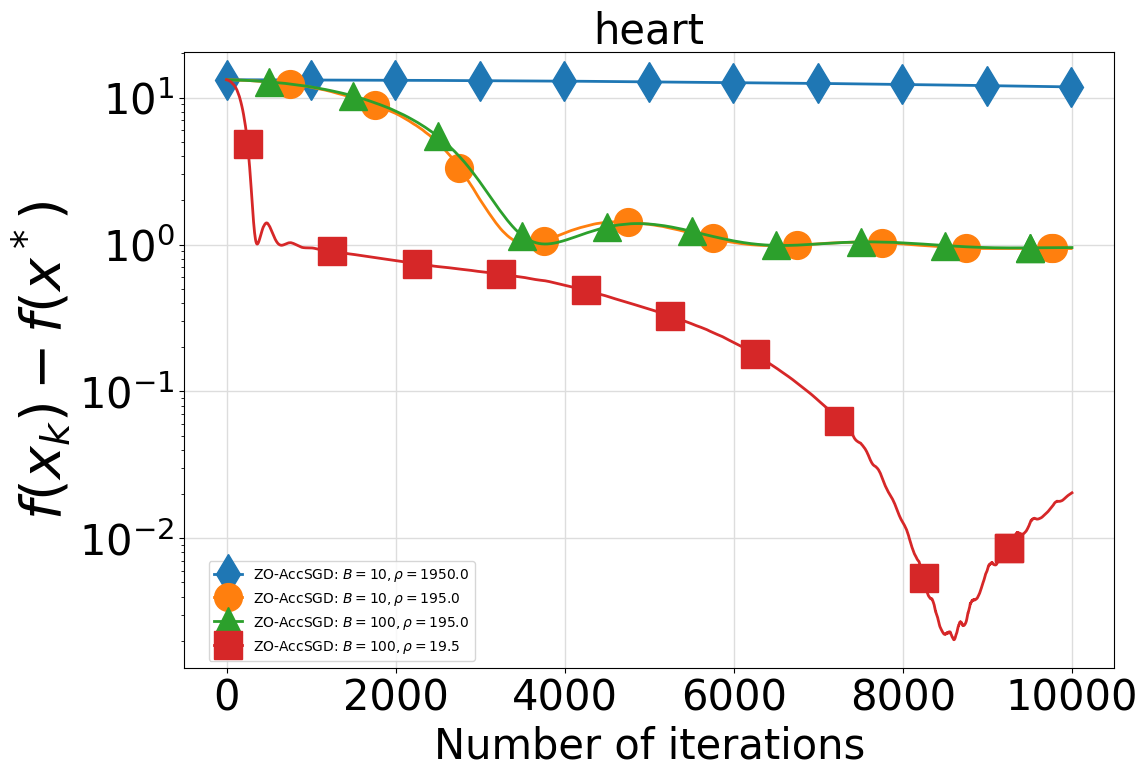

In [65]:
methods = []
N = 10000
step_param = 1
batch_sizes = [10, 100]
overbatching_cnst = 4 * A.shape[1] * (3 * 125)
delta = 0

for bs in batch_sizes:
    theoretical_rho = max(1, overbatching_cnst / bs)
    rhos = [theoretical_rho, theoretical_rho / 10] 
    for rho in rhos:
        methods.append(['Our_algorithm logreg', [step_param, N, delta, bs, rho],
                        fr"ZO-AccSGD: $B = {bs}, \rho = {rho}$", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+"_rho_"+str(rho)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [10]:
%%time
t = 1e-10
N = 3704
stepsizes = [1e-3, 1e-4, 1e-5, 1e-6]
bs = 100
delta = 0
for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    rdfds_e_res = rdfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

100%|██████████| 10000/10000 [00:01<00:00, 8418.36it/s]


Finished with stepsize parameter =  0.001


100%|██████████| 10000/10000 [00:01<00:00, 8773.83it/s]


Finished with stepsize parameter =  0.0001


100%|██████████| 10000/10000 [00:01<00:00, 8604.44it/s]


Finished with stepsize parameter =  1e-05


100%|██████████| 10000/10000 [00:01<00:00, 8883.82it/s]

Finished with stepsize parameter =  1e-06
CPU times: total: 4.7 s
Wall time: 4.81 s


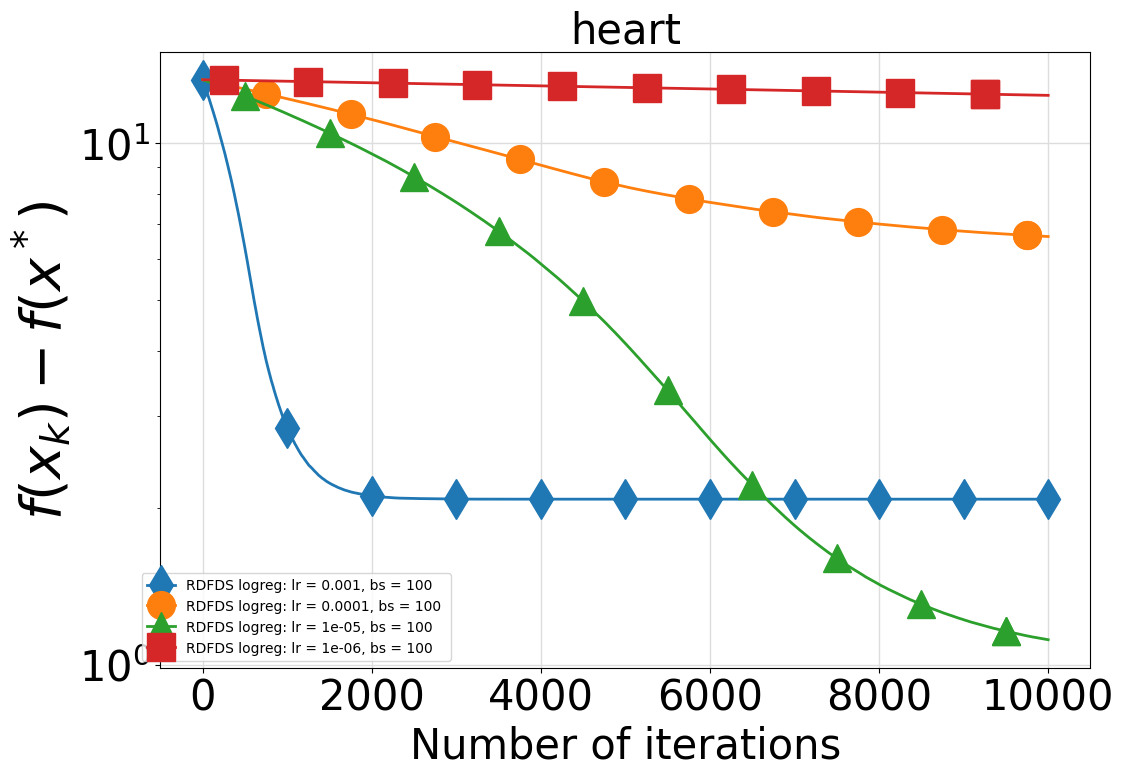

In [11]:
methods = []
N = 3704
stepsizes = [1e-3, 1e-4, 1e-5, 1e-6]
bs = 100
delta = 0
for step_param in stepsizes:
    methods.append(['RDFDS_E logreg', [step_param, N, delta, bs],
                        f"RDFDS logreg: lr = {step_param}, bs = {bs} ", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"RDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [12]:
%%time
t = 1e-10
N = 3704
stepsizes = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
bs = 100
delta = 0
for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    ardfds_e_res = ardfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

100%|██████████| 10000/10000 [00:01<00:00, 6594.38it/s]


Finished with stepsize parameter =  1


100%|██████████| 10000/10000 [00:01<00:00, 7501.30it/s]


Finished with stepsize parameter =  0.1


100%|██████████| 10000/10000 [00:01<00:00, 7704.29it/s]


Finished with stepsize parameter =  0.01


100%|██████████| 10000/10000 [00:01<00:00, 7920.43it/s]


Finished with stepsize parameter =  0.001


100%|██████████| 10000/10000 [00:01<00:00, 7654.33it/s]


Finished with stepsize parameter =  0.0001


100%|██████████| 10000/10000 [00:01<00:00, 8036.15it/s]


Finished with stepsize parameter =  1e-05


100%|██████████| 10000/10000 [00:01<00:00, 8049.68it/s]


Finished with stepsize parameter =  1e-06


100%|██████████| 10000/10000 [00:01<00:00, 7720.27it/s]


Finished with stepsize parameter =  1e-07


100%|██████████| 10000/10000 [00:01<00:00, 8078.89it/s]


Finished with stepsize parameter =  1e-08


100%|██████████| 10000/10000 [00:01<00:00, 8029.51it/s]

Finished with stepsize parameter =  1e-09
CPU times: total: 13 s
Wall time: 13.1 s


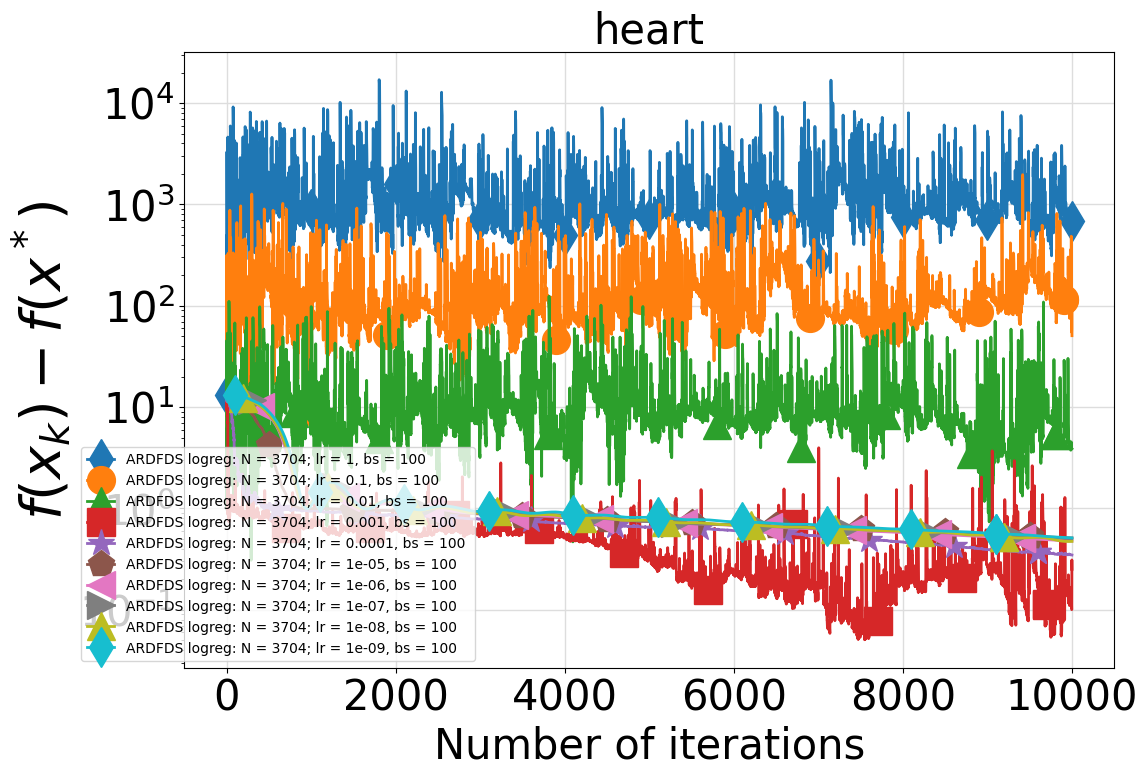

In [13]:
methods = []
N = 3704
stepsizes = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
bs = 100
delta = 0
for step_param in stepsizes:
    methods.append(['ARDFDS_E logreg', [step_param, N, delta, bs],
                        f"ARDFDS logreg: N = {N}; lr = {step_param}, bs = {bs} ", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"ARDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [13]:
%%time
t = 1e-10
N = 370
stepsizes = [1e-3, 1e-4, 1e-5, 1e-6]
bs = 10
delta = 0
for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    rdfds_e_res = rdfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

  4%|▍         | 435/9990 [00:00<00:02, 4349.13it/s]

100%|██████████| 9990/9990 [00:02<00:00, 3920.76it/s]


Finished with stepsize parameter =  0.001


100%|██████████| 9990/9990 [00:02<00:00, 3807.22it/s]


Finished with stepsize parameter =  0.0001


100%|██████████| 9990/9990 [00:02<00:00, 3747.58it/s]


Finished with stepsize parameter =  1e-05


100%|██████████| 9990/9990 [00:02<00:00, 3875.51it/s]

Finished with stepsize parameter =  1e-06
CPU times: total: 10.4 s
Wall time: 10.5 s


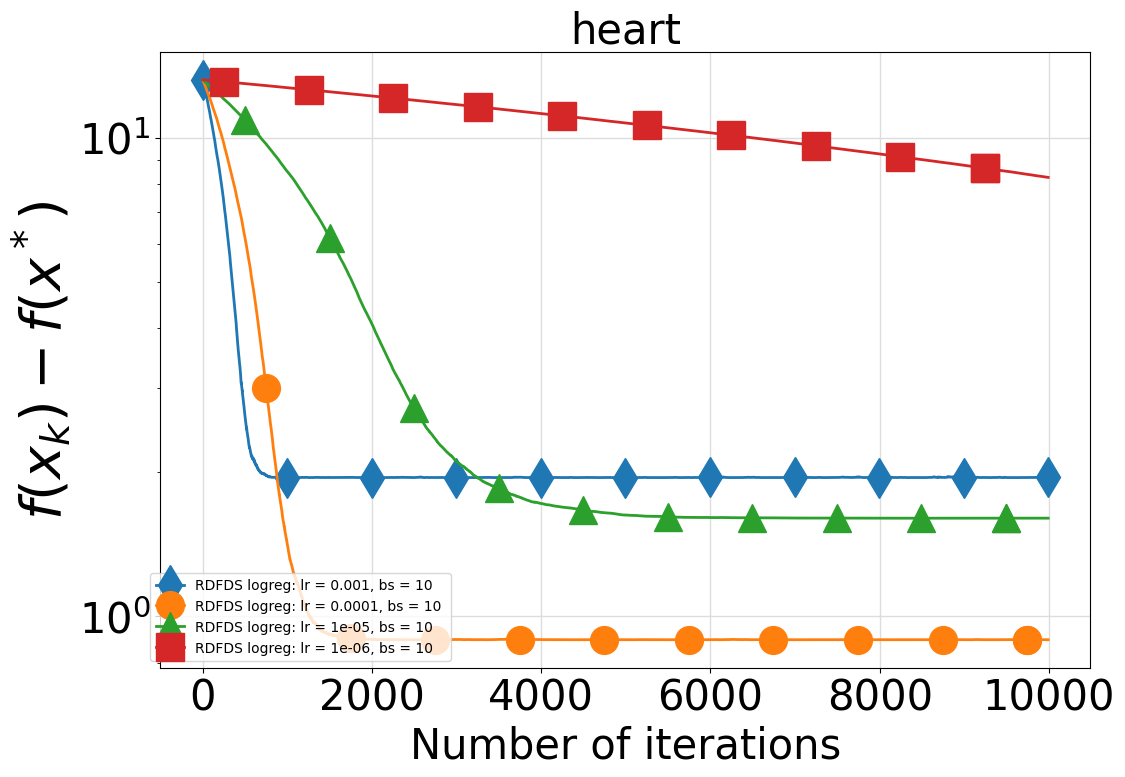

In [14]:
methods = []
N = 370
stepsizes = [1e-3, 1e-4, 1e-5, 1e-6]
bs = 10
delta = 0
for step_param in stepsizes:
    methods.append(['RDFDS_E logreg', [step_param, N, delta, bs],
                        f"RDFDS logreg: lr = {step_param}, bs = {bs} ", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"RDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [15]:
%%time
t = 1e-10
N = 370
stepsizes = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
bs = 10
delta = 0
for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    ardfds_e_res = ardfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

100%|██████████| 9990/9990 [00:02<00:00, 3359.03it/s]


Finished with stepsize parameter =  1


100%|██████████| 9990/9990 [00:02<00:00, 4029.15it/s]


Finished with stepsize parameter =  0.1


100%|██████████| 9990/9990 [00:02<00:00, 4518.47it/s]


Finished with stepsize parameter =  0.01


100%|██████████| 9990/9990 [00:02<00:00, 4769.09it/s]


Finished with stepsize parameter =  0.001


100%|██████████| 9990/9990 [00:01<00:00, 5066.48it/s]


Finished with stepsize parameter =  0.0001


100%|██████████| 9990/9990 [00:02<00:00, 4352.62it/s]


Finished with stepsize parameter =  1e-05


100%|██████████| 9990/9990 [00:02<00:00, 4081.94it/s]


Finished with stepsize parameter =  1e-06


100%|██████████| 9990/9990 [00:02<00:00, 4262.70it/s]


Finished with stepsize parameter =  1e-07


100%|██████████| 9990/9990 [00:02<00:00, 4732.31it/s]


Finished with stepsize parameter =  1e-08


100%|██████████| 9990/9990 [00:01<00:00, 5162.98it/s]


Finished with stepsize parameter =  1e-09
CPU times: total: 22.8 s
Wall time: 23.1 s


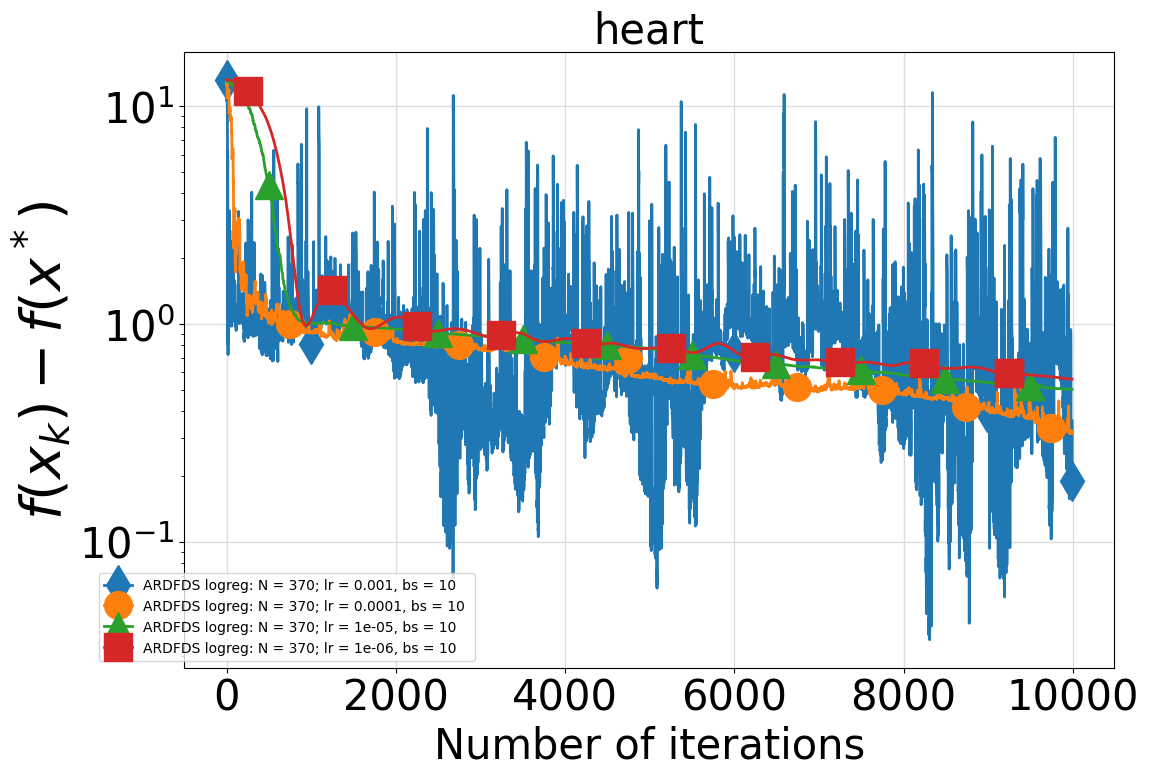

In [18]:
methods = []
N = 370
stepsizes = [1e-3, 1e-4, 1e-5, 1e-6]
bs = 10
delta = 0
for step_param in stepsizes:
    methods.append(['ARDFDS_E logreg', [step_param, N, delta, bs],
                        f"ARDFDS logreg: N = {N}; lr = {step_param}, bs = {bs} ", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"ARDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

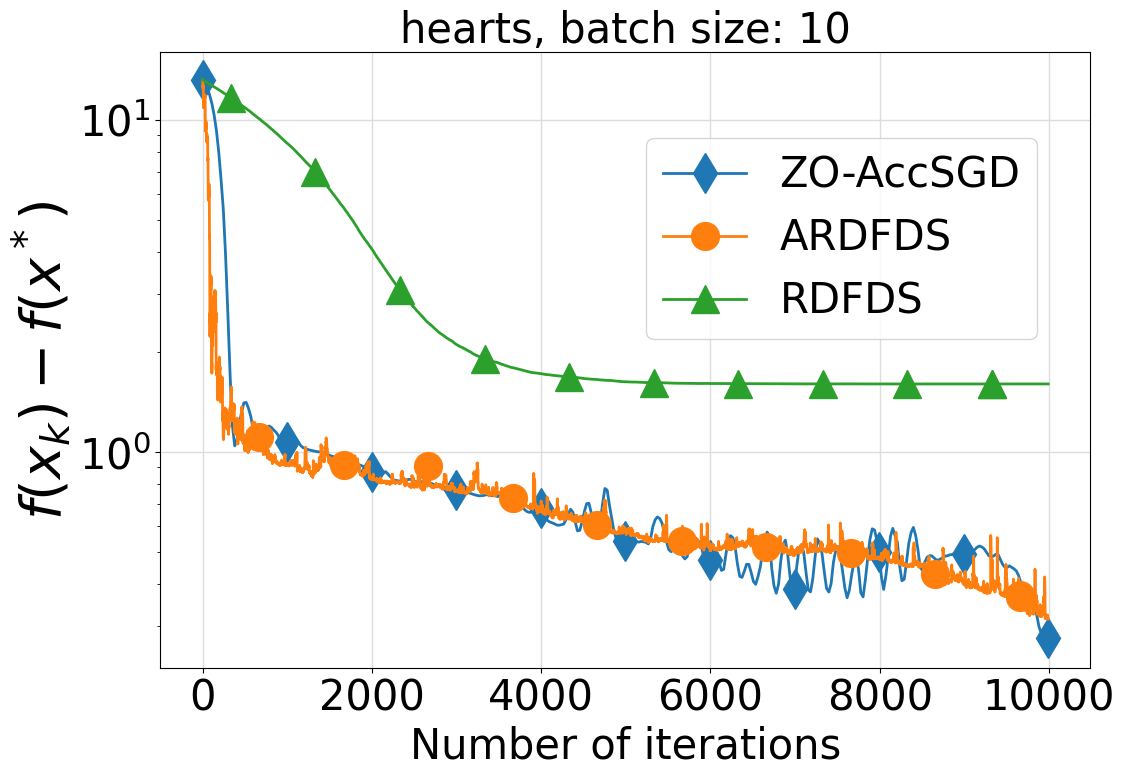

In [20]:
methods = [['Our_algorithm logreg', [1, 10000, 0, 10, 19.5], f"ZO-AccSGD", None], 
           ['ARDFDS_E logreg', [1e-4, 370, 0, 10], f"ARDFDS", None],
           ['RDFDS_E logreg', [1e-5, 370, 0, 10], f"RDFDS", None]]

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 30
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = 'hearts, batch size: 10'
bbox_to_anchor = (0.5,0.5)
legend_loc='best'

save_fig = [True, filename+"comparison"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

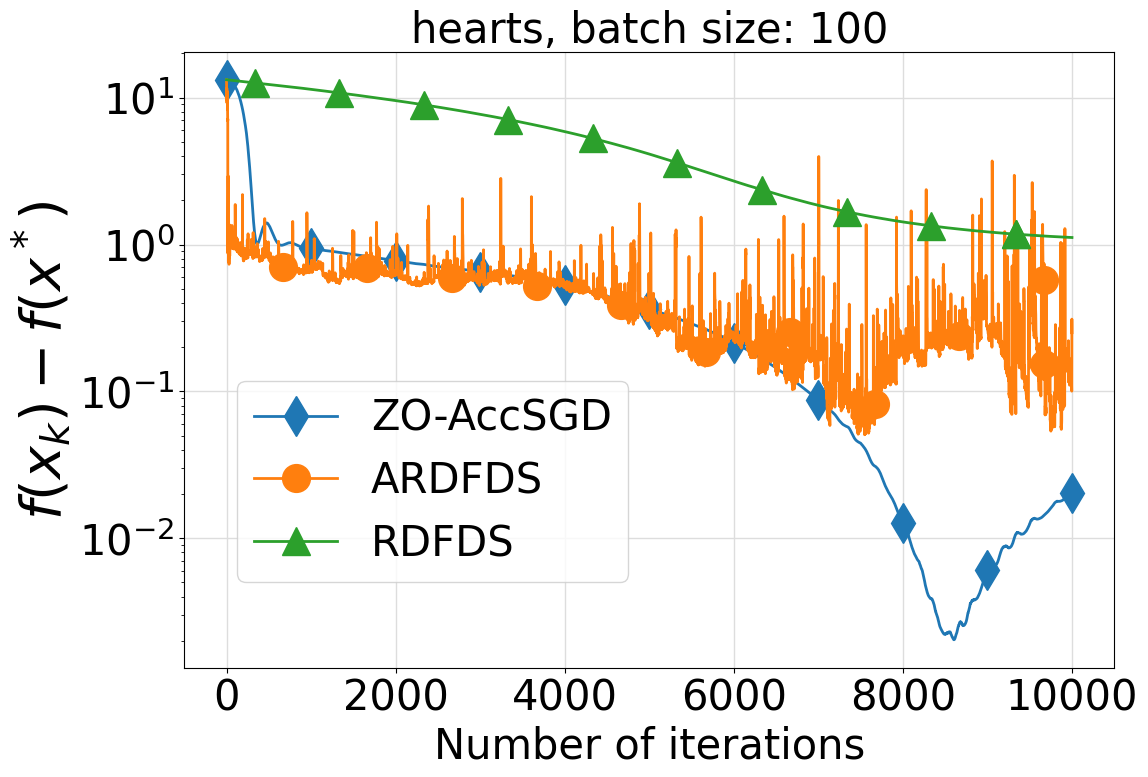

In [20]:
methods = [['Our_algorithm logreg', [1, 10000, 0, 100, 19.5], f"ZO-AccSGD", None], 
           ['ARDFDS_E logreg', [1e-3, 3704, 0, 100], f"ARDFDS", None],
           ['RDFDS_E logreg', [1e-5, 3704, 0, 100], f"RDFDS", None]]

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 30
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = 'hearts, batch size: 100'
bbox_to_anchor = (0.5,0.5)
legend_loc='best'

save_fig = [True, filename+"comparison"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [21]:
N = 10000
step_param = 1
bs = A.shape[0]
overbatching_cnst = 4 * A.shape[1] * (3 * 125)
t = 1e-10
delta = 0

print(f'Theoretical overbatching cnst is {overbatching_cnst}')
theoretical_rho = max(1, overbatching_cnst / bs)
rhos = [theoretical_rho, theoretical_rho / 10]

for rho in rhos:
    args = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]

    Our_method = ZO_AccSGD(filename, x_init, args=args, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=1)
    
    print(f'Finished, params: rho = {rho}, t = {t}')

Theoretical overbatching cnst is 19500
72.22222222222223


100%|██████████| 10000/10000 [25:47<00:00,  6.46it/s]


Finished, params: rho = 72.22222222222223, t = 1e-10
7.222222222222223


100%|██████████| 10000/10000 [26:05<00:00,  6.39it/s]

Finished, params: rho = 7.222222222222223, t = 1e-10


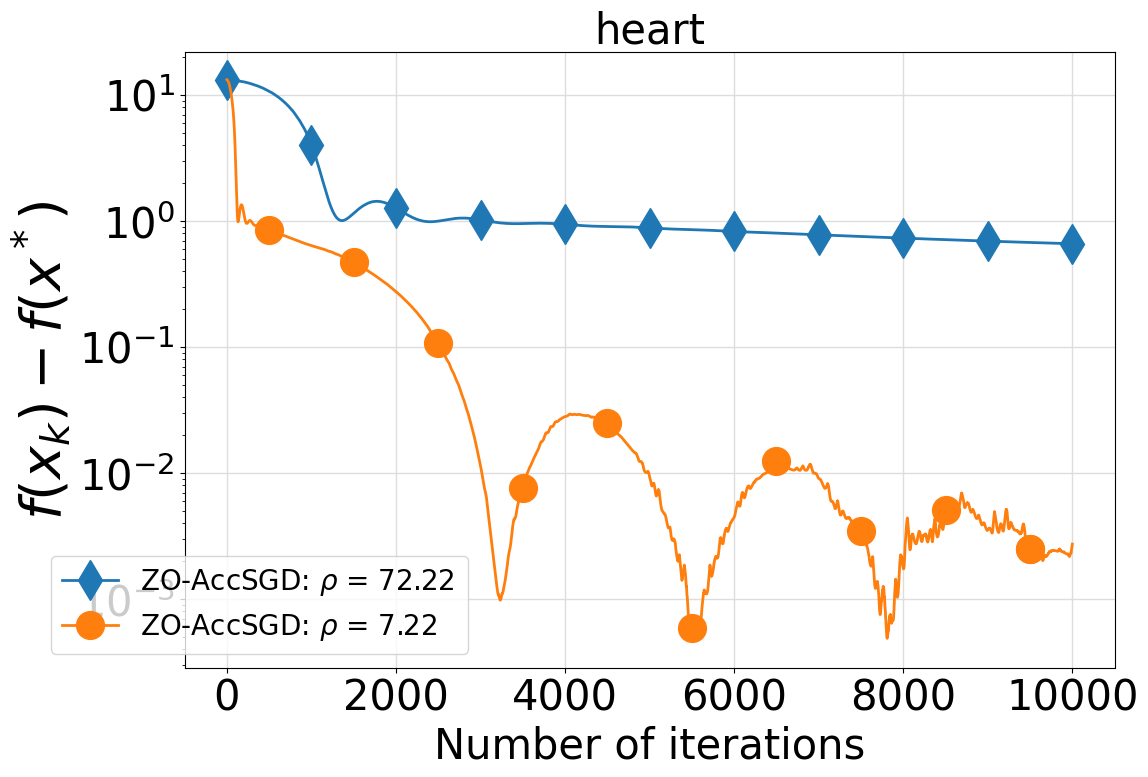

In [24]:
methods = []
for rho in rhos:
    methods.append(['Our_algorithm logreg', [step_param, N, delta, bs, rho],
                        fr"ZO-AccSGD: $\rho$ = {rho:.2f} ", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [35]:
%%time
N = 10000
stepsizes = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
bs = A.shape[0]
delta = 0
for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    rdfds_e_res = rdfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

100%|██████████| 10000/10000 [00:01<00:00, 7148.83it/s]


Finished with stepsize parameter =  0.1


100%|██████████| 10000/10000 [00:01<00:00, 7568.31it/s]


Finished with stepsize parameter =  0.01


100%|██████████| 10000/10000 [00:01<00:00, 7215.36it/s]


Finished with stepsize parameter =  0.001


100%|██████████| 10000/10000 [00:01<00:00, 7246.32it/s]


Finished with stepsize parameter =  0.0001


100%|██████████| 10000/10000 [00:01<00:00, 7568.60it/s]


Finished with stepsize parameter =  1e-05


100%|██████████| 10000/10000 [00:01<00:00, 7158.43it/s]


Finished with stepsize parameter =  1e-06


100%|██████████| 10000/10000 [00:01<00:00, 7634.13it/s]

Finished with stepsize parameter =  1e-07
CPU times: total: 9.97 s
Wall time: 10 s


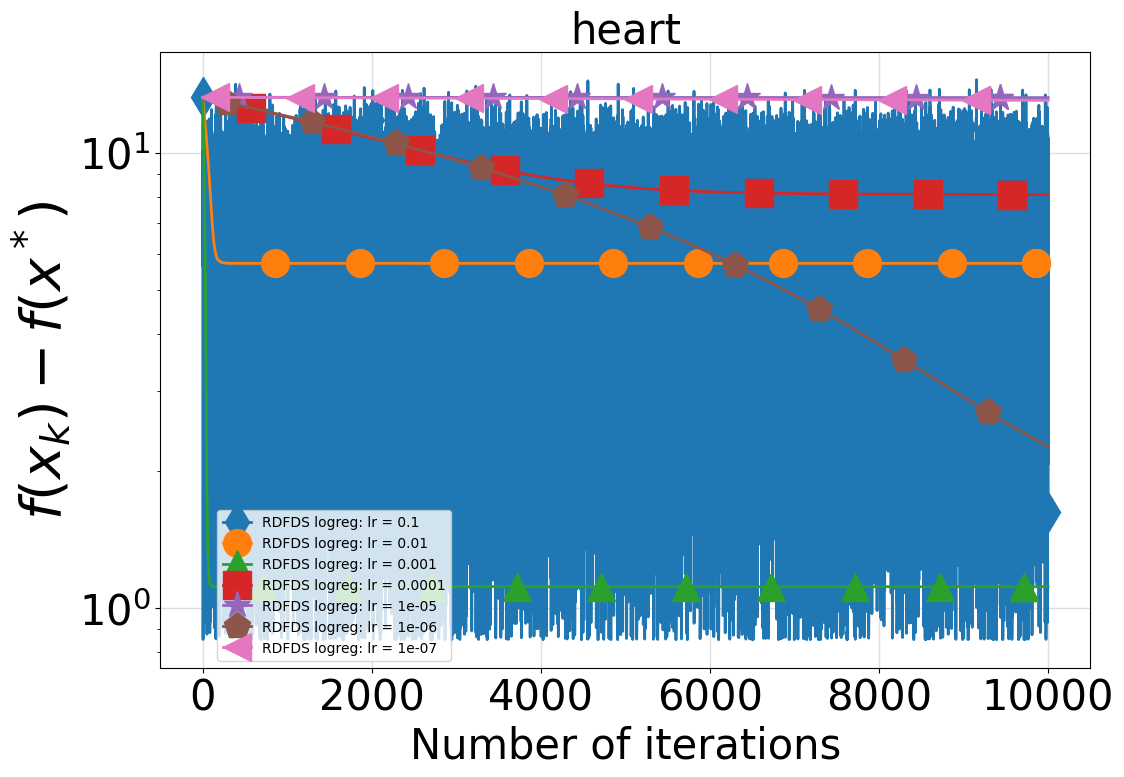

In [36]:
methods = []
N = 10000
stepsizes = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
bs = A.shape[0]
delta = 0
for step_param in stepsizes:
    methods.append(['RDFDS_E logreg', [step_param, N, delta, bs],
                        f"RDFDS logreg: lr = {step_param}", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"RDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [33]:
%%time
t = 1e-10
N = 10000
stepsizes = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
bs = A.shape[0]
delta = 0
for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    ardfds_e_res = ardfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

100%|██████████| 10000/10000 [00:01<00:00, 5511.12it/s]


Finished with stepsize parameter =  1


100%|██████████| 10000/10000 [00:01<00:00, 6592.56it/s]


Finished with stepsize parameter =  0.1


100%|██████████| 10000/10000 [00:01<00:00, 6432.84it/s]


Finished with stepsize parameter =  0.01


100%|██████████| 10000/10000 [00:01<00:00, 6718.91it/s]


Finished with stepsize parameter =  0.001


100%|██████████| 10000/10000 [00:01<00:00, 6810.38it/s]


Finished with stepsize parameter =  0.0001


100%|██████████| 10000/10000 [00:01<00:00, 6508.47it/s]


Finished with stepsize parameter =  1e-05


100%|██████████| 10000/10000 [00:01<00:00, 6824.81it/s]

Finished with stepsize parameter =  1e-06
CPU times: total: 10.9 s
Wall time: 10.9 s


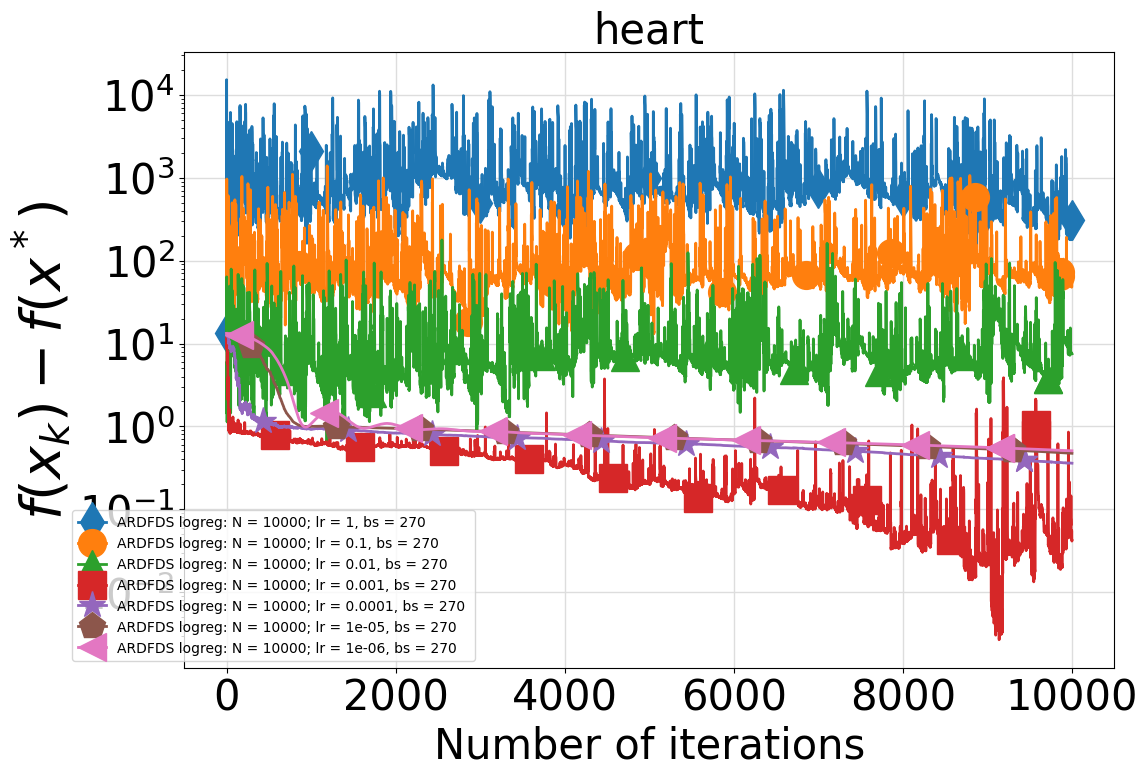

In [34]:
methods = []
N = 10000
stepsizes = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
bs = A.shape[0]
delta = 0
for step_param in stepsizes:
    methods.append(['ARDFDS_E logreg', [step_param, N, delta, bs],
                        f"ARDFDS logreg: N = {N}; lr = {step_param}, bs = {bs} ", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"ARDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

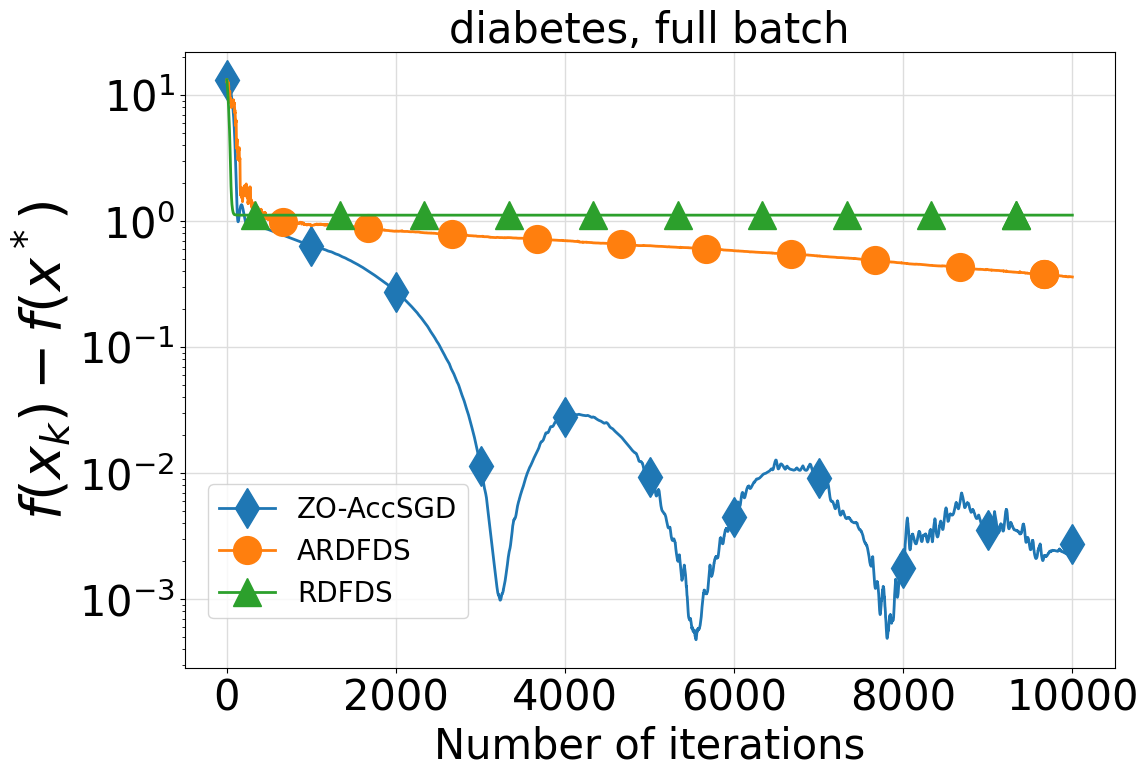

In [42]:
N = 10000
stepsizes = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
bs = A.shape[0]
delta = 0

methods = [['Our_algorithm logreg', [1, N, 0, bs, rho], f"ZO-AccSGD", None],
           ['ARDFDS_E logreg', [1e-4, N, 0, bs], f"ARDFDS", None],
           ['RDFDS_E logreg', [1e-3, N, 0, bs], f"RDFDS", None]]

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = 'diabetes, full batch'
bbox_to_anchor = (0.32,0.32)
legend_loc='best'

save_fig = [True, filename+"comparison_small"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)